# Data modelling on Bike Sharing data

Data aquired from: https://s3.amazonaws.com/capitalbikeshare-data/index.html  
Data project initiated: 25/01/2019  
Author: Sedar Olmez

In [61]:
# Libraries
from __future__ import print_function
import matplotlib.pyplot as plt
import seaborn as sea
import pandas as pd
import numpy as np
from datetime import date
from IPython.display import Image
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.cluster import KMeans

## Small dataset - Walking_Cycling.csv

In [10]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_journeys = pd.read_csv('data/Walking-Cycling.csv')
dataframe_journeys.columns = ['LA code', 'Local Authority', 'Year', 'Frequency', 'Walking_%', 'Cycling_%']
dataframe_journeys.dropna()

CPU times: user 6.78 ms, sys: 3.63 ms, total: 10.4 ms
Wall time: 11.8 ms


In [11]:
dataframe_journeys.head()

,LA code,Local Authority,Year,Frequency,Walking_%,Cycling_%
0,E09000001,City of London,2010/11,1x per month,78,30
1,E09000002,Barking and Dagenham,2010/11,1x per month,60,8
2,E09000003,Barnet,2010/11,1x per month,65,10
3,E09000004,Bexley,2010/11,1x per month,65,11
4,E09000005,Brent,2010/11,1x per month,62,14


In [12]:
list(dataframe_journeys)

['LA code', 'Local Authority', 'Year', 'Frequency', 'Walking_%', 'Cycling_%']

In [13]:
# We will now convert the Local Authority column to string
dataframe_journeys['Local Authority'] = dataframe_journeys['Local Authority'].astype('|S')

In [14]:
dataframe_journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 6 columns):
LA code            1204 non-null object
Local Authority    1204 non-null object
Year               1204 non-null object
Frequency          1204 non-null object
Walking_%          1204 non-null int64
Cycling_%          1204 non-null object
dtypes: int64(1), object(5)
memory usage: 56.5+ KB


#### In Pandas, dtype(obj) == python.dtype(str) therefore we set the string to the maximum bytes of the longest string stored by using

```.astype(|S)```

In [15]:
# An invalit literal for long() error is thrown, this means there are values in the column which cannot be converted to int
# Let us identify these columns
dataframe_journeys['Cycling_%'] = pd.to_numeric(dataframe_journeys['Cycling_%'], errors='coerce')

In [16]:
# We found the row with the problem, for row 326 the column Cycling_% had '-' so we replaced it with NaN.
print (dataframe_journeys[ pd.to_numeric(dataframe_journeys['Cycling_%'], errors='coerce').isnull()])

       LA code Local Authority     Year    Frequency  Walking_%  Cycling_%
326  E09000026       Redbridge  2011/12  5x per week         17        NaN


In [17]:
# We must replace the NaN to an integer value i.e. 0 so we can produce a pairplot later using seaborn.
dataframe_journeys = dataframe_journeys.fillna(0.0)

In [59]:
# Here we convert Walking_% to float from int
dataframe_journeys['Walking_%'] = dataframe_journeys['Walking_%'].astype(float)

In [60]:
# As can be seen, we converted the columns to floats.
dataframe_journeys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 6 columns):
LA code            1204 non-null object
Local Authority    1204 non-null object
Year               1204 non-null object
Frequency          1204 non-null object
Walking_%          1204 non-null float64
Cycling_%          1204 non-null float64
dtypes: float64(2), object(4)
memory usage: 56.5+ KB


In [14]:
dataframe_journeys.head()

,LA code,Local Authority,Year,Frequency,Walking_%,Cycling_%
0,E09000001,City of London,2010/11,1x per month,78.0,30.0
1,E09000002,Barking and Dagenham,2010/11,1x per month,60.0,8.0
2,E09000003,Barnet,2010/11,1x per month,65.0,10.0
3,E09000004,Bexley,2010/11,1x per month,65.0,11.0
4,E09000005,Brent,2010/11,1x per month,62.0,14.0


## Dataset cleaned and optimised, now to explore we will use another dataset on the bikeshare data in washington DC for the year 2017 (already cleaned)

In [4]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_washington = pd.read_csv('data/2017-capitalbikeshare-tripdata-washington.csv')
dataframe_washington.columns = ['Duration', 'Start Date', 'End Date', 'Start Station Number', 'Start Station Name', 'End Station Number',
                                'End Station Name', 'Bike Number', 'Member Type']
dataframe_washington.dropna()

CPU times: user 2.75 s, sys: 152 ms, total: 2.91 s
Wall time: 1.5 s


In [63]:
dataframe_washington.head(1)

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,NaN,Member


In [17]:
dataframe_washington.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 646510 entries, 0 to 646509
Data columns (total 9 columns):
Duration                646510 non-null int64
Start Date              646510 non-null object
End Date                646510 non-null object
Start Station Number    646510 non-null int64
Start Station Name      646510 non-null object
End Station Number      646510 non-null int64
End Station Name        646510 non-null object
Bike Number             646510 non-null object
Member Type             646510 non-null object
dtypes: int64(3), object(6)
memory usage: 44.4+ MB


In [18]:
# We can strip the 'W' from the Bike Numbers to convert it into an Integer which we can then add to our visualisation 
# Data manipulation for later.
dataframe_washington['Bike Number'] = dataframe_washington['Bike Number'].str[1:]

In [64]:
# The problematic rows were identified
dataframe_washington['Bike Number'] = pd.to_numeric(dataframe_washington['Bike Number'], errors='coerce')
dataframe_washington[ pd.to_numeric(dataframe_washington['Bike Number'], errors='coerce').isnull()].head(1)

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
0,221,2017-01-01 00:00:41,2017-01-01 00:04:23,31634,3rd & Tingey St SE,31208,M St & New Jersey Ave SE,NaN,Member


In [20]:
# Filled all the NaN rows with 0 for Bike Number.
dataframe_washington = dataframe_washington.fillna(0)

In [21]:
# I now converted the Bike Number column to integer so we can add it to our data analysis.
dataframe_washington['Bike Number'] = dataframe_washington['Bike Number'].astype(int)

In [22]:
# We know that the Member Type column has only two categories `members` and `casual`, we can use the .value_counts()
# method to explore further.
dataframe_washington['Member Type'].value_counts()

Member    528434
Casual    118076
Name: Member Type, dtype: int64

In [6]:
# We can also run value_countr() on the stations because we have repetitive values:
dataframe_washington['Start Station Name'].value_counts().head()

Columbus Circle / Union Station         13712
Massachusetts Ave & Dupont Circle NW     9071
15th & P St NW                           8195
Jefferson Dr & 14th St SW                8026
Lincoln Memorial                         7876
Name: Start Station Name, dtype: int64

## Lets run some queries

In [65]:
# Lets have a look at all the Lincoln Memorial Start Station journeys.
dataframe_washington.loc[dataframe_washington['Start Station Name']=='Lincoln Memorial', :].head(1)

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
1,1676,2017-01-01 00:06:53,2017-01-01 00:34:49,31258,Lincoln Memorial,31270,8th & D St NW,NaN,Casual


In [66]:
## Has anyone started at Lincoln Memorial and Ended up at Maine Ave & 7th St SW?
dataframe_washington.loc[(dataframe_washington['Start Station Name'] =='Lincoln Memorial') & 
                         (dataframe_washington['End Station Name'] == 'Maine Ave & 7th St SW'), :].head(1)

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
68066,1388,2017-01-14 15:35:35,2017-01-14 15:58:44,31258,Lincoln Memorial,31609,Maine Ave & 7th St SW,NaN,Member


In [27]:
## 185 has been used quite a lot actually, let us now write a method which counts the number of times something appears.
def counter(column, object_name):
    counter_index = 0
    for i in range(dataframe_washington[column].size):
        if(dataframe_washington[column].iloc[i] == object_name):
            counter_index += 1
    return counter_index

In [28]:
# As we can see, in 2017 the bike 185 was used 214 times.
print(counter('Bike Number', 185))

214


In [29]:
# Let's have a look at how many times members commuted and compare that to the number of times 
# casual people commuted with bikes.
print(counter('Member Type', 'Member'))

528434


In [30]:
# And now how many times casual users used the bikes in Washington:
print(counter('Member Type', 'Casual'))

118076


## More members have used the bikes during 2017 than casual users. Almost 5 times the number of casual users. 

1. We will use the [Capital Bikeshare API](https://secure.capitalbikeshare.com/map/) to visualise a docking station and see if we can pinpoint the furthest distance travelled from that station.
2. We will try to deduce how many people ended their journey at a docking station which is the closest to a museum. 

## The first docking station we will concentrate on is `Constitution Ave & 2nd St NW/DOL`

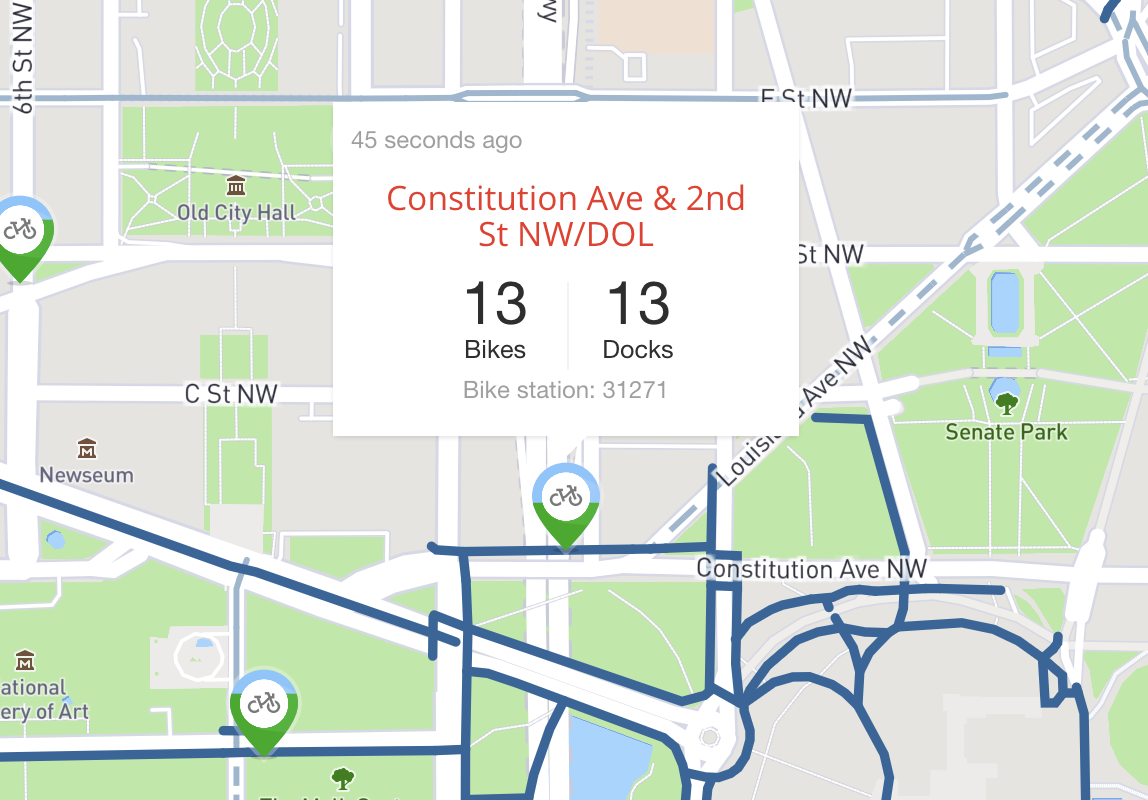

In [17]:
Image(filename="Const_ave.png", width="800", height="900")

In [31]:
# Now lets define a method which will tell us if a value exists in a column.
def data_identification(column_name, value):
    for i in range (dataframe_washington[column_name].size):
        if (dataframe_washington[column_name].iloc[i] == value):
            return ("Value Exists!")
            break

In [32]:
# We check to see if the station number 31271 does exist in our dataset, that way we know the API and dataset are callibrated
print(data_identification('Start Station Number', 31271))

Value Exists!


In [33]:
#Now we want to see the furthest distance travelled from the station 31271. We first assign the rows with the station
#start number = 31271 to the variable list_of_stations.
list_of_stations = dataframe_washington.loc[dataframe_washington['Start Station Number'] == 31271, :]
#We now run the max() function on the `Duration` column to return the maximum duration
list_of_stations['Duration'].max()

81885

## The maximum duration of travel from the starting station `Constitution Ave & 2nd St NW/DOL` was `01` hour, `15` minutes and `14` seconds. The `end station` was the same as start station and the user was a `member`. 

In [34]:
list_of_stations.loc[list_of_stations['Duration'] == 81885]

,Duration,Start Date,End Date,Start Station Number,Start Station Name,End Station Number,End Station Name,Bike Number,Member Type
228091,81885,2017-02-08 08:46:57,2017-02-09 07:31:43,31271,Constitution Ave & 2nd St NW/DOL,31271,Constitution Ave & 2nd St NW/DOL,20197,Member


## Now for the second question, the memorial/museum we will focus on is:

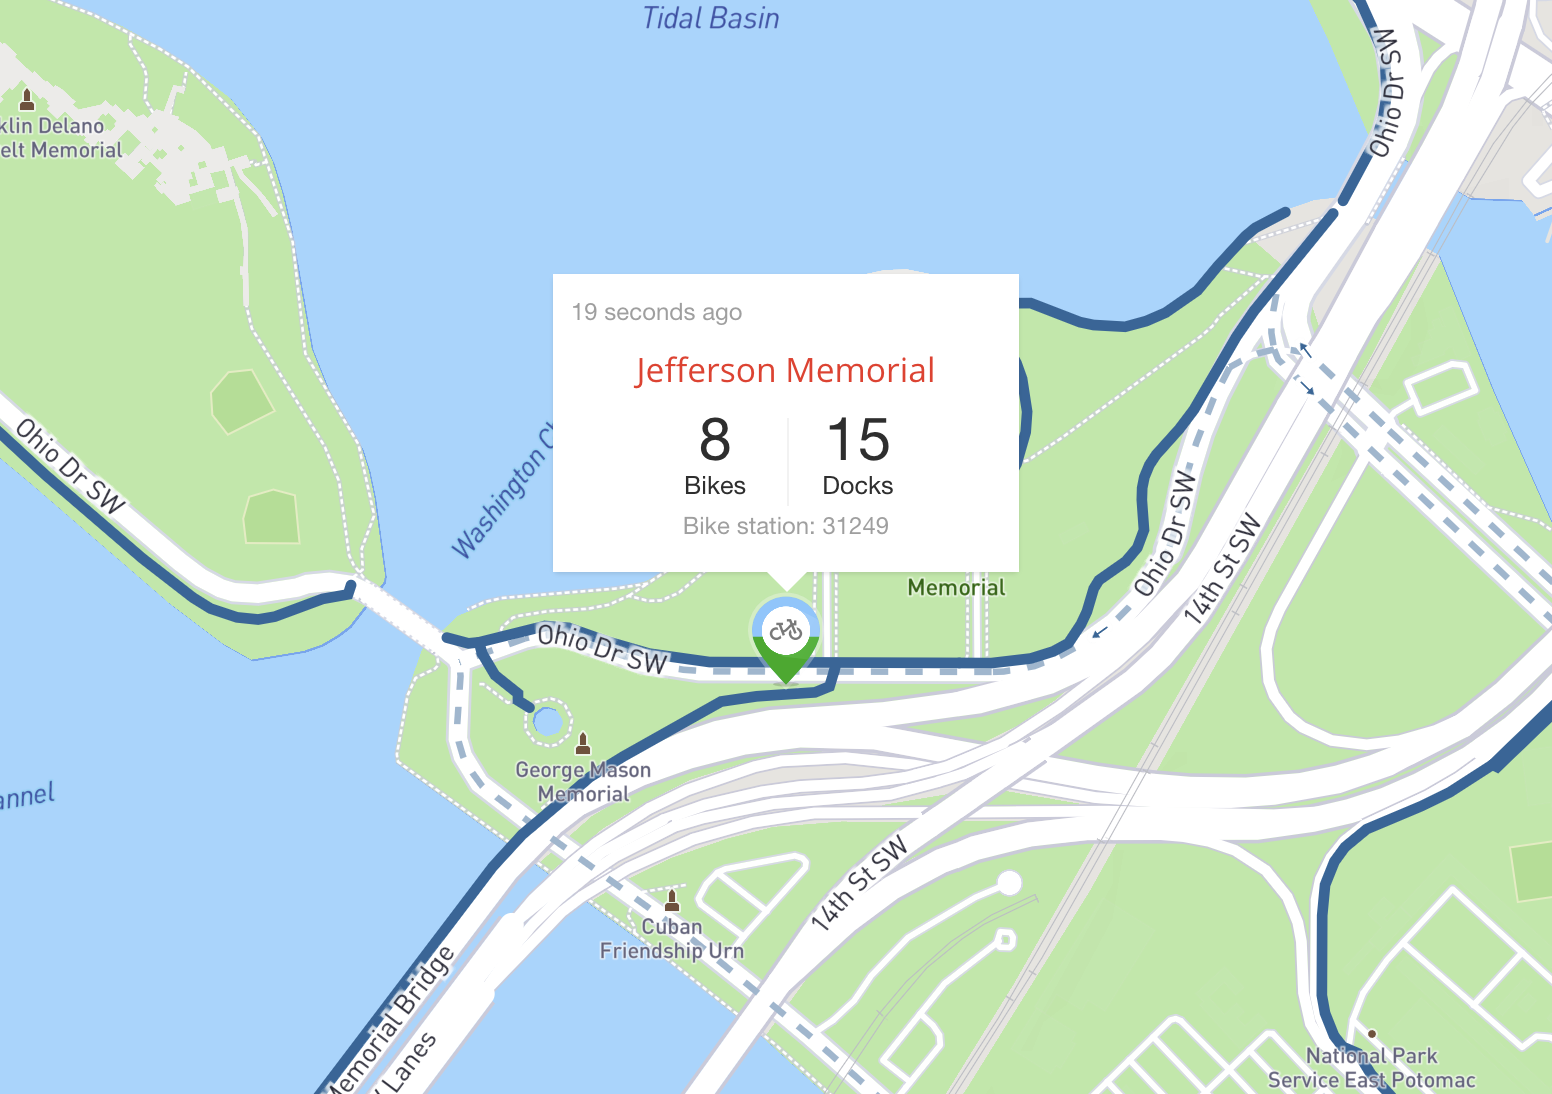

In [16]:
Image(filename="Jefferson Mem.png", width="800", height="900")

In [35]:
# We made use of our `counter` method and just counted how many times the End Station was the Jefferson Memorial.
print(counter('End Station Number', 31249))

5970


## The number of bike rides which ended at the Jefferson Memorial were `5970` 

# Now we will further explore our dataset visually.

In [36]:
sea.set(style="darkgrid")

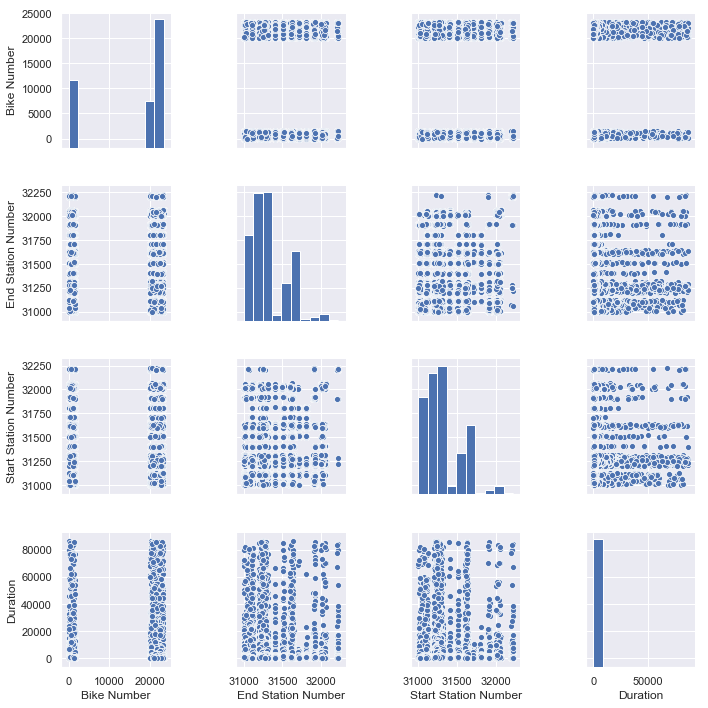

In [37]:
columns = ['Bike Number', 'End Station Number', 'Start Station Number', 'Duration']
sea.pairplot(dataframe_washington[columns])
plt.tight_layout()
plt.show()

In [38]:
columns = ['Bike Number', 'Duration']
bike_duration = dataframe_washington[columns]

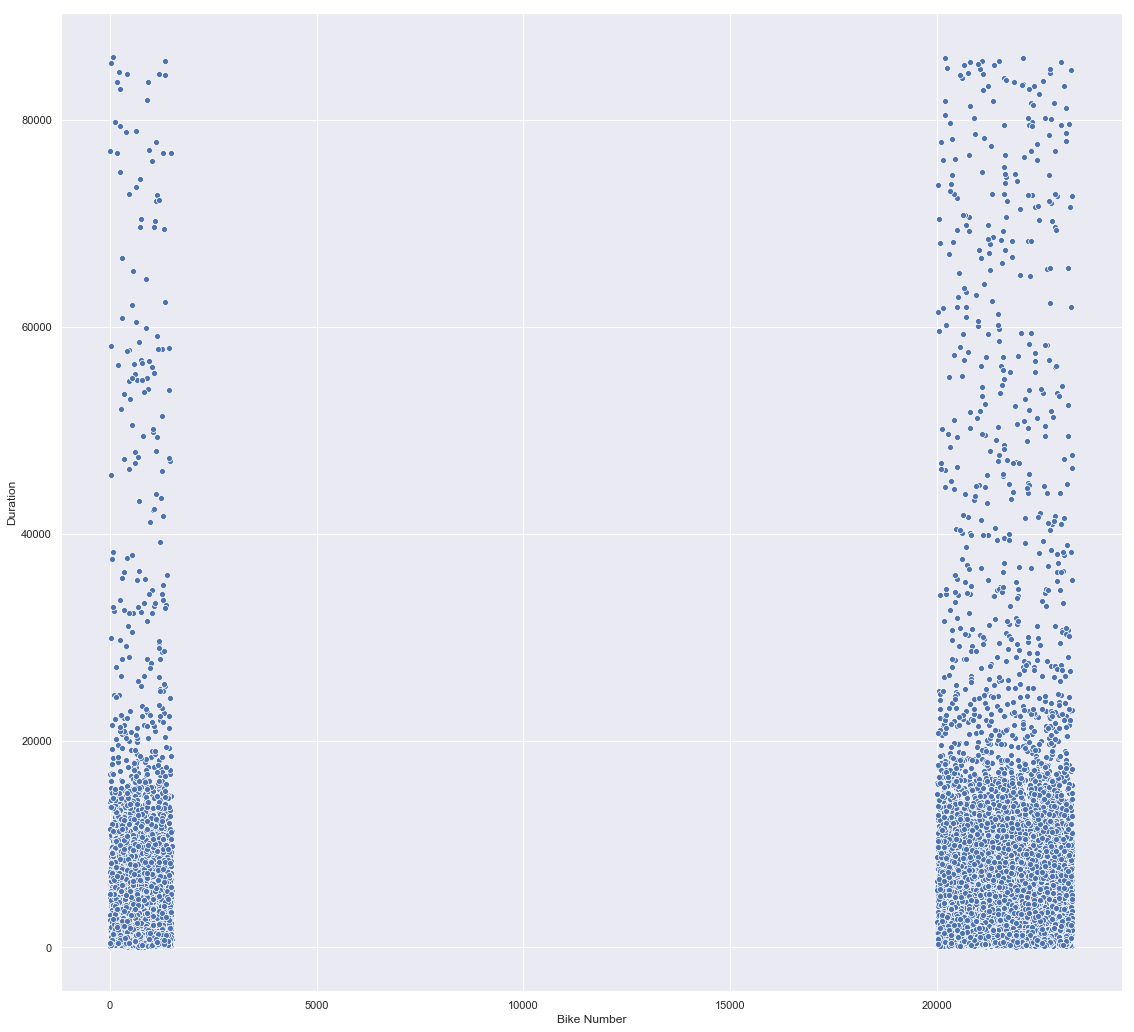

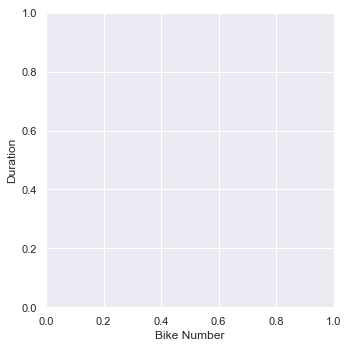

In [39]:
# Ignore the small empty scatter at the bottom, I don't know why it keeps appearing!
dimensions = (19, 18)
fig, ax = plt.subplots(figsize=dimensions)
# Using the seaborn relplot algorithm parsing the X axis Bike Number and Y axis for Duration
# This way we can see the number of bikes which have travelled longer distances.
sea.relplot(x='Bike Number', y='Duration',
            data=bike_duration, ax=ax);

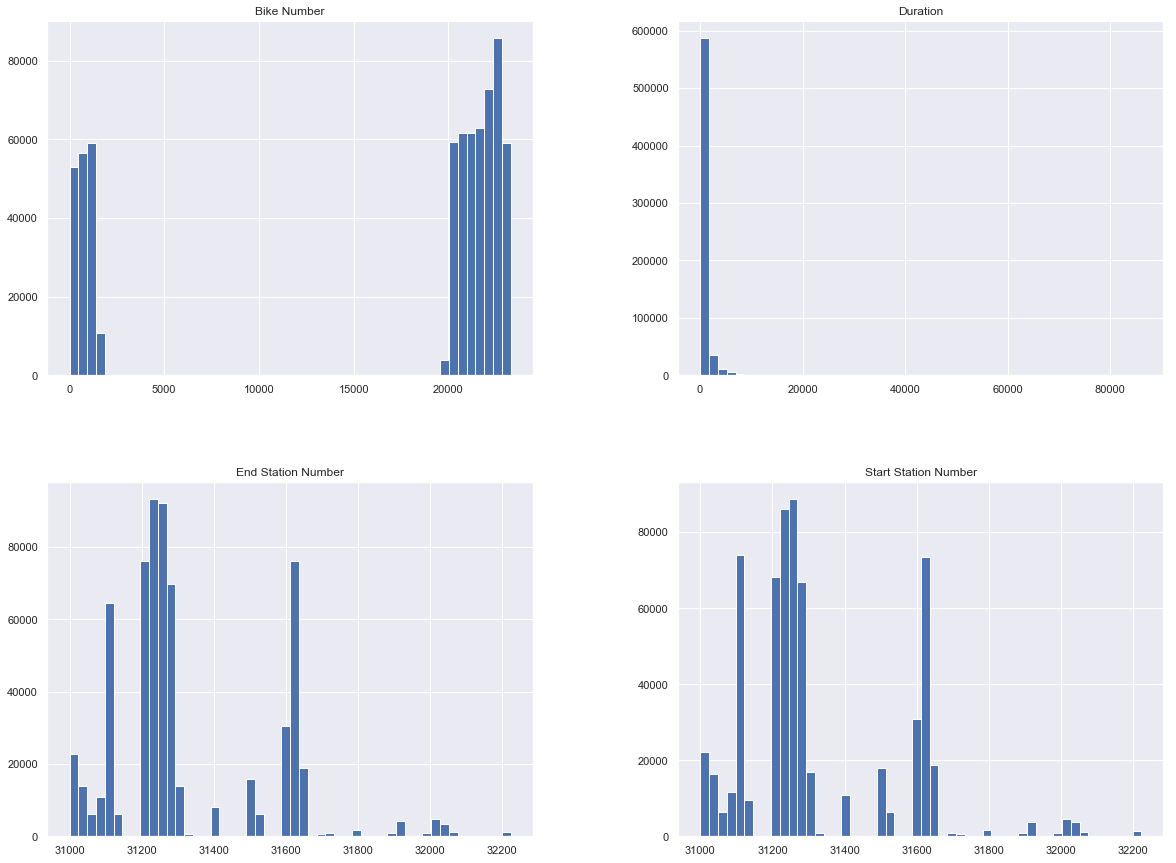

In [40]:
%matplotlib inline
# We create an histagram of all the numerical data.
import matplotlib.pyplot as plt
dataframe_washington.hist(bins=50, figsize=(20, 15))
plt.show()

In [41]:
# Creating a test set, we will develop a function to do this for us:
def train_test(data, test_ratio):
    np.random.seed(42)
    shuffled = np.random.permutation(len(data))
    testset_size = int(len(data) * test_ratio)
    test_indices = shuffled[:testset_size]
    train_indices = shuffled[testset_size]
    return dataframe_washington.iloc[train_indices], dataframe_washington.iloc[test_indices]

In [42]:
train_set, test_set = train_test(dataframe_washington, 0.2)

In [43]:
len(train_set)

9

In [44]:
len(test_set)

129302

## We can run some basic regression techniques on the data like RMSE (Root Mean Squared Error)

In [45]:
from zlib import crc32

In [46]:
# We create the crc32 hash of each instances identifier.
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

In [47]:
# This function splits the data into test set and training set according to an id
def train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [48]:
# We create a new index column from 0 to n = size of dataset.
by_id = dataframe_washington.reset_index()

In [49]:
train_set_v2, test_set_v2 = train_test_by_id(by_id, 0.2, "index")

## The previous train_test splitter method would break if a new dataset was loaded into the notebook, to bypass that problem. A new solution would be the train_test_by_id in which we use each instance's identifier to decide wheter or not it should go in the test set. 

In [50]:
len(train_set_v2)

517205

In [51]:
len(test_set_v2)

129305

## I would like to visualise the destination of each bike share dock. Our main dataset doesn't have a latitude/longitude column for us to do this, therefore, for this visualisation we will use a temporary dataset of Bike Share docks in Melbourne.

The data can be found here: [Bike Data](https://data.melbourne.vic.gov.au/Transport-Movement/Bike-Share-Dock-Locations/vrwc-rwgm) `COLUMNS: 'station_id'	'Name'	'Rental_Method'	'Capacity'	'Latitude'	'Longitude'	'Location'`

In [67]:
%%time
# Load up the journeys.csv dataset into dataframes
dataframe_melbourne = pd.read_csv('data/Bike_Share_Dock_Locations.csv')
dataframe_melbourne.columns = ['station_id', 'Name', 'Rental_Method', 'Capacity', 'Latitude', 'Longitude', 'Location']
dataframe_melbourne.dropna()

CPU times: user 5.6 ms, sys: 2.84 ms, total: 8.44 ms
Wall time: 9.09 ms


In [68]:
dataframe_melbourne.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 7 columns):
station_id       50 non-null int64
Name             50 non-null object
Rental_Method    50 non-null object
Capacity         50 non-null int64
Latitude         50 non-null float64
Longitude        50 non-null float64
Location         50 non-null object
dtypes: float64(2), int64(2), object(3)
memory usage: 2.8+ KB


In [69]:
dataframe_melbourne.head(1)

,station_id,Name,Rental_Method,Capacity,Latitude,Longitude,Location
0,52,Flagstaff Gardens - Peel St - West Melbourne,"CREDITCARD,KEY",11,-37.809216,144.955223,"(-37.809216, 144.955223)"


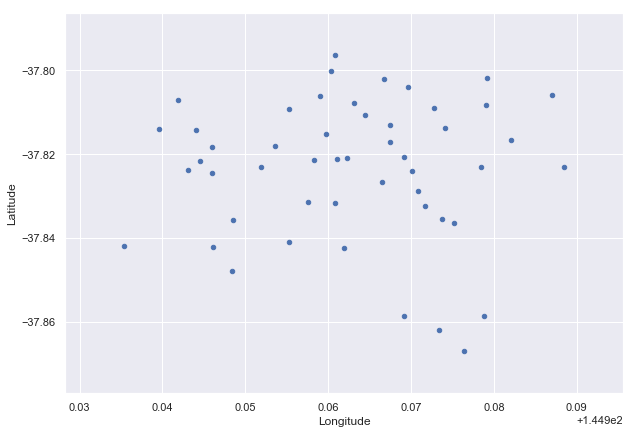

In [56]:
dataframe_melbourne.plot(kind = "scatter", x = "Longitude", y = "Latitude", figsize = (10, 7));

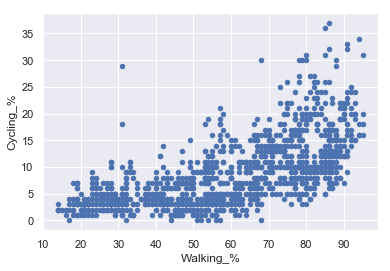

In [57]:
# We can create a scatter of the walking and cycling % of our journeys dataframe (first dataset)
dataframe_journeys.plot(kind = "scatter", x = "Walking_%", y = "Cycling_%")

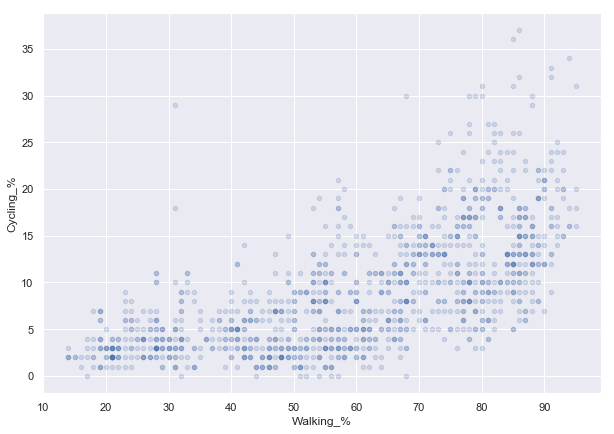

In [58]:
# If we want to see the high density points, we can set alpha to 0.1
dataframe_journeys.plot(kind = "scatter", x = "Walking_%", y = "Cycling_%", alpha = 0.2, figsize = (10, 7))

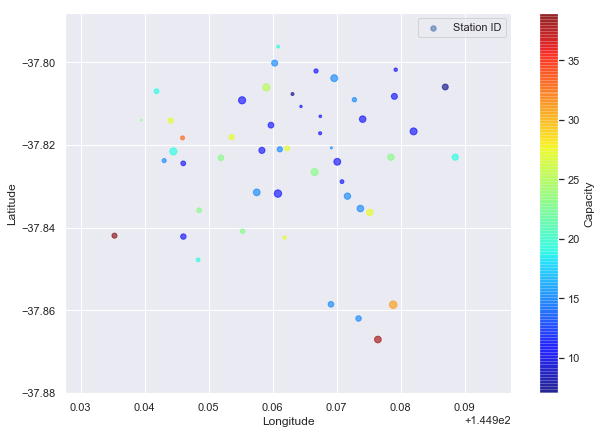

In [59]:
fig, ax = plt.subplots()
# We can see that there are more lower capacity stations around melbourne than larger capacity stations.
dataframe_melbourne.plot(kind = "scatter", x = "Longitude", y = "Latitude", alpha = 0.6,
                       s = dataframe_melbourne["station_id"], label = "Station ID", figsize = (10, 7),
                        c = "Capacity", cmap=plt.get_cmap("jet"), colorbar = True, ax=ax)

plt.legend();

### From the visualisation above, we can see that there are more stations with smaller capacities (hold bikes) than ones that hold over 30 - 35 bikes. There are only 2 docks that hold 30 bikes and two that hold 35.

In [60]:
# Lets calculate the standard correlation coefficient.
correlation_matrix = dataframe_washington.corr()

In [61]:
correlation_matrix["Duration"].sort_values(ascending = False)

Duration                1.000000
Bike Number             0.002834
Start Station Number   -0.011554
End Station Number     -0.015248
Name: Duration, dtype: float64

In [24]:
# Here we will convert the Member Type column to numbers for machine learning algorithms.
members_category = dataframe_washington['Member Type']

In [25]:
# We convert the category data into numerical data.
members_type_encoded, members_cat = members_category.factorize()

In [26]:
members_type_encoded[:10]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0])

In [27]:
# Member = 0 and Casual = 1
members_cat

Index([u'Member', u'Casual'], dtype='object')

In [29]:
encoder = OneHotEncoder()
members_cat_1hot = encoder.fit_transform(members_type_encoded.reshape(-1, 1))
members_cat_1hot

<646510x2 sparse matrix of type '<type 'numpy.float64'>'
	with 646510 stored elements in Compressed Sparse Row format>

In [67]:
members_cat_1hot.toarray()

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]])

## Let's perform some linear regression on our dataset.

In [33]:
# We need to create a pipeline to modify the dataset making it ready for machine learning algorithms.
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y = None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [34]:
class DenseTransformer(TransformerMixin):

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, y=None, **fit_params):
        return X.todense()

In [38]:
# We are trying to convert a dataframe into a numpy array (only chosen attributes to feed into our pipeline)
columns_01 = ['Duration', 'Start Station Number', 'End Station Number', 'Bike Number']
num_attributes = dataframe_washington[columns_01]
number_attributes = list(num_attributes)
category_attributes = ['Member Type']

# We used pipelines to improve our models by parsing data from one function to another making the data handling and processing much more smoother.

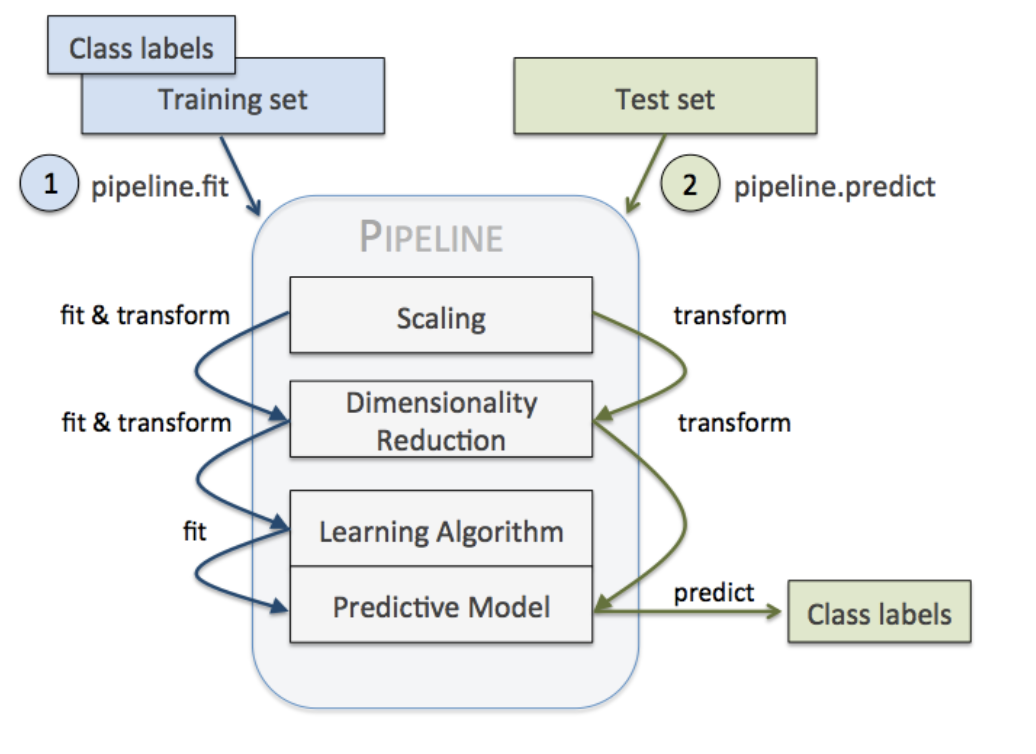

In [39]:
Image(filename="pipeline.png", width="800", height="900")

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
# The pipeline with number attributes only.
number_pipeline = Pipeline([
    ('selector', DataFrameSelector(number_attributes)),
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler()),
])
# The pipeline with category type attribtes like `member type`.
category_pipeline = Pipeline([
    ('selector', DataFrameSelector(category_attributes)),
    ('hot_encoder', OneHotEncoder()),
])

In [41]:
from sklearn.pipeline import FeatureUnion
# Now we need a pipeline to handle both numerical and categorical pipelines
pipeline_full = FeatureUnion(transformer_list = [
    ('number_pipeline', number_pipeline),
    ('category_pipeline', category_pipeline),
])

In [42]:
data_prepared = pipeline_full.fit_transform(dataframe_washington)
data_prepared.toarray()

array([[-0.37826415,  1.45201146, -0.51831296,  0.        ,  1.        ],
       [ 0.31890206, -0.27248935, -0.23179855,  1.        ,  0.        ],
       [ 0.16557341, -0.13030976, -0.45361616,  1.        ,  0.        ],
       ...,
       [-0.28147544,  1.4199064 ,  1.35789427,  0.        ,  1.        ],
       [ 0.01799458, -0.47887907,  1.32092467,  0.        ,  1.        ],
       [-0.37730585, -0.97880085, -1.00353897,  0.        ,  1.        ]])

In [43]:
data_prepared.shape

(646510, 5)

In [44]:
dataframe_labels = dataframe_washington['Duration'].copy()

In [45]:
linear_reg = LinearRegression()
linear_reg.fit(data_prepared, dataframe_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [46]:
some_data = dataframe_washington.iloc[:30]
some_labels = dataframe_labels.iloc[:30]
some_data_prepared = pipeline_full.transform(some_data)
print("Predictions: ", linear_reg.predict(some_data_prepared))

Predictions:  [  221.  1676.  1356.  1327.  1636.  1603.   473.   200.   748.   912.
   383.   600.  2062.  2017.   404.   981.   750.   195.   244.   280.
   555.   543.   483.   216. 36943.  1903.   228.   653.   414.   427.]


In [47]:
print("Labels: ", list(some_labels))

Labels:  [221, 1676, 1356, 1327, 1636, 1603, 473, 200, 748, 912, 383, 600, 2062, 2017, 404, 981, 750, 195, 244, 280, 555, 543, 483, 216, 36943, 1903, 228, 653, 414, 427]


## We performed linear regression on 30 rows of data and when we compared the predictions with the labels we can see that our algorithm matched perfectly, this is because the values used are not floating point but integer. Again we reiterate that this dataset is suited more for clustering not regression analysis.

## Lets measure the regression models RMSE

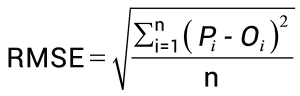

In [48]:
Image(filename="rmse.png", width="300", height="200")

In [49]:
washington_predictions = linear_reg.predict(data_prepared)
linear_mse = mean_squared_error(dataframe_labels, washington_predictions)
linear_rmse = np.sqrt(linear_mse)
linear_rmse

2.932417522529887e-10

## 2.2 error rate, this is really good, it means the training model and labels are very closely correlated.

In [50]:
# Lets try something more complex, a decision tree regressor:
tree_regressor = DecisionTreeRegressor()
tree_regressor.fit(data_prepared, dataframe_labels)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [51]:
washington_predictions = tree_regressor.predict(data_prepared)
tree_mse = mean_squared_error(dataframe_labels, washington_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

## No error at all! It is more likely that the model has overfitted the data. 

## K-Fold cross validation

In [52]:
scores_tree = cross_val_score(tree_regressor, data_prepared, dataframe_labels,
                        scoring = "neg_mean_squared_error", cv = 10)
tree_rmse_scores = np.sqrt(-scores_tree)

In [53]:
scores_linear_regression = cross_val_score(linear_reg, data_prepared, dataframe_labels,
                                           scoring = "neg_mean_squared_error", cv = 10)
linear_rmse_scores = np.sqrt(-scores_linear_regression)

In [54]:
def display_results(scores):
    print("Scores: ", scores)
    print("Mean: ", scores.mean())
    print("Standard deviation: ", scores.std())

In [55]:
display_results(scores_tree)

Scores:  [-18.50447789 -34.79531639 -21.83717189 -32.02312416 -35.96570819
 -19.28089279 -29.49006203 -16.9690028  -80.05585374 -39.38031894]
Mean:  -32.83019288178063
Standard deviation:  17.492574709393732


In [56]:
display_results(scores_linear_regression)

Scores:  [-4.73078802e-21 -1.08828633e-19 -8.77573208e-21 -2.77439158e-20
 -5.53885186e-20 -6.32676885e-20 -7.55442476e-21 -1.37967439e-19
 -1.08048012e-19 -2.75995185e-21]
Mean:  -5.2506510333205793e-20
Standard deviation:  4.794602787158333e-20


## The tree regressor seems to perform worse than the linear regression method. The standard deviation tells us how accurate this estimate is. It is clear given these values that `decision tree regression` is overfitting a lot. 

In [90]:
# Lets try and compare the Random Forest Regression.
forest_regression = RandomForestRegressor()
forest_regression.fit(data_prepared, dataframe_labels)
washington_predictions_v3 = forest_regression.predict(data_prepared)
forest_mse = mean_squared_error(dataframe_labels, washington_predictions_v3)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

/miniconda2/lib/python2.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.7751306169005938

## It is clear that random forest regression is much better than both linear regression and decision tree regression. But the model still overfits, some tuning would have to be done to minimise the overfitting. One solution could be to simplify the model.

In [91]:
scores_forest = cross_val_score(forest_regression, data_prepared, dataframe_labels,
                        scoring = "neg_mean_squared_error", cv = 3)
forest_rmse_scores = np.sqrt(-scores_forest)
display_results(scores_forest)

Scores:  [-21.95177134 -29.67161441 -36.21492383]
Mean:  -29.279436524825844
Standard deviation:  5.8295072622942445


## Clustering of all the bike stations in Melbourne from our `dataframe_melbourne` dataset

In [119]:
dataframe_melbourne.fillna(97000)
dataframe_melbourne.dropna(axis=0,how='any',subset=['Latitude','Longitude'],inplace=True)
X=dataframe_melbourne.loc[:,['Latitude','Longitude']]
zp=dataframe_melbourne

In [120]:
#run KMeans
kmeans = KMeans(n_clusters=8, random_state=0).fit(X)
id_label=kmeans.labels_

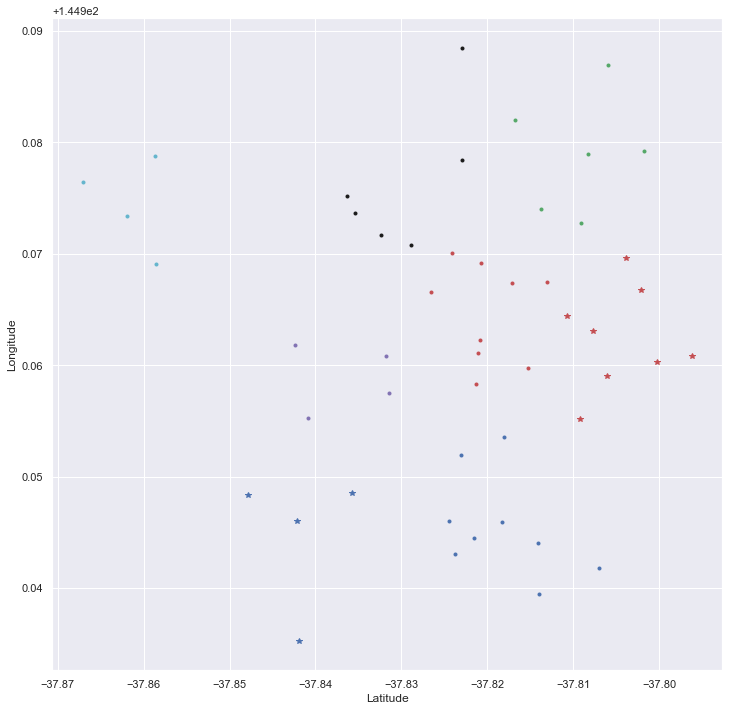

In [122]:
#plot result
ptsymb = np.array(['b.','r.','m.','g.','c.','k.','b*','r*','m*','r^']);
plt.figure(figsize=(12,12))
plt.ylabel('Longitude', fontsize=12)
plt.xlabel('Latitude', fontsize=12)
for i in range(8):
    cluster=np.where(id_label==i)[0]
    plt.plot(X.Latitude[cluster].values,X.Longitude[cluster].values,ptsymb[i])
plt.show()

In [92]:
from sklearn.model_selection import learning_curve

In [100]:
train_sizes = [1, 10, 14, 20, 29, 40]

train_sizes, train_scores, validation_scores = learning_curve(
                                                   estimator = LinearRegression(), X = data_prepared,
                                                   y = dataframe_labels, train_sizes = train_sizes, cv = 5,
                                                   scoring = 'neg_mean_squared_error')

The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              
The exact solution is  x = 0                              


In [101]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-0.00000000e+00 -0.00000000e+00 -0.00000000e+00 -0.00000000e+00
  -0.00000000e+00]
 [-2.59556998e-23 -1.59194786e-22 -1.59194786e-22 -1.59194786e-22
  -1.59194786e-22]
 [-7.04326751e-24 -7.33730732e-20 -7.33730732e-20 -7.33730732e-20
  -7.33730732e-20]
 [-1.18099419e-25 -6.57170763e-23 -6.57170763e-23 -6.57170763e-23
  -6.57170763e-23]
 [-3.94871779e-24 -2.34686620e-11 -2.34686620e-11 -2.34686620e-11
  -2.34686620e-11]
 [-3.03698069e-24 -1.98503620e-12 -1.98503620e-12 -1.98503620e-12
  -1.98503620e-12]]

 ----------------------------------------------------------------------

Validation scores:

 [[-4.26507474e+06 -3.88679343e+06 -6.11655399e+06 -4.08912355e+06
  -6.31479890e+06]
 [-7.24407194e+03 -1.97049188e-22 -2.09423731e-22 -1.99229232e-22
  -2.01022495e-22]
 [-1.01290446e+04 -4.92383929e-20 -4.92085675e-20 -4.96502316e-20
  -4.81301074e-20]
 [-9.89803245e+03 -4.45721475e-23 -4.46903373e-23 -4.48781846e-23
  -4.32310290e-23]
 [-7.68434490e-24 -1.85311834e-12 -

In [102]:
train_scores_mean = -train_scores.mean(axis = 1)
validation_scores_mean = -validation_scores.mean(axis = 1)

print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) # separator
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))

Mean training scores

 1    -0.000000e+00
10    1.325470e-22
14    5.869987e-20
20    5.259728e-23
29    1.877493e-11
40    1.588029e-12
dtype: float64

 --------------------

Mean validation scores

 1     4.934469e+06
10    1.448814e+03
14    2.025809e+03
20    1.979606e+03
29    1.879796e-12
40    2.192287e-13
dtype: float64


(0, 50)

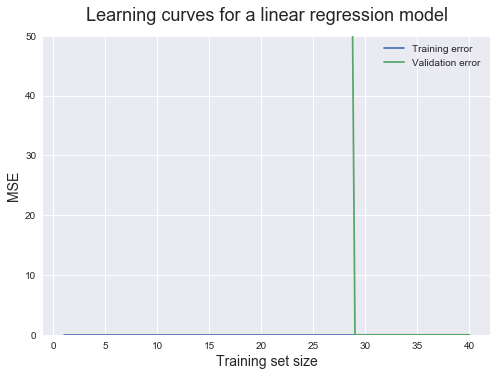

In [104]:
%matplotlib inline

plt.style.use('seaborn')

plt.plot(train_sizes, train_scores_mean, label = 'Training error')
plt.plot(train_sizes, validation_scores_mean, label = 'Validation error')

plt.ylabel('MSE', fontsize = 14)
plt.xlabel('Training set size', fontsize = 14)
plt.title('Learning curves for a linear regression model', fontsize = 18, y = 1.03)
plt.legend()
plt.ylim(0,50)